In [1]:
import matplotlib.pyplot as plt
import nest
import numpy as np

import os
import sys
    
from pynestml.frontend.pynestml_frontend import generate_nest_target
NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")   
    
%matplotlib inline


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Mar 23 2022 13:33:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
nest.Install("nestmlmodule")
neuron_model_name = "edlif_psc_percent" # "iaf_psc_alpha" "edlif_psc_percent"
#neuron_model_name = "iaf_psc_alpha"


Jun 22 16:11:28 Install [Info]: 
    loaded module nestmlmodule


In [3]:
# parameters
## simulation
simtime = 50
iterations = 1
seed = 4
dim = 3
exc_circular_conn = True
inh_circular_conn = True
if dim == 2:
    mask = "circular"
elif dim == 3:
    mask = "spherical"

## excitatory neurons
exc_neuron_type = neuron_model_name
exc_positions = nest.spatial.free(
    nest.random.uniform(min=-0.5, max=0.5),  # using random positions in a uniform distribution
    num_dimensions=dim  # have to specify number of dimensions
    )
exc_n = 200
exc_ndict = {"I_e": 200.0, "tau_m": 20.0}

## inhibitory neurons
inh_neuron_type = neuron_model_name
inh_positions = nest.spatial.free(
    nest.random.uniform(min=-0.5, max=0.5),  
    num_dimensions=dim)
inh_n = 100
inh_ndict = {"I_e": 200.0, "tau_m": 20.0}

## noise generatos
exc_noise_type = "poisson_generator"
inh_noise_type = "poisson_generator"
exc_rate = 80000  # rate in Hz
inh_rate  = 15000

## connections
# https://nest-simulator.readthedocs.io/en/v3.3/tutorials/pynest_tutorial/part_4_spatially_structured_networks.html#pynest-tutorial-4
# https://nest-simulator.readthedocs.io/en/v3.3/guides/spatially_structured_networks.html#spatial-networks
### exc to inh
exc_d = 1.0
exc_synapse_model = "stdp_synapse"
exc_inh_wr = nest.Create('weight_recorder')
nest.CopyModel(exc_synapse_model, "exc_synapse_rec", {"weight_recorder": exc_inh_wr})
exc_alpha_min = 0.1
exc_alpha_max = 2.
exc_alpha = nest.random.uniform(min=exc_alpha_min, max=exc_alpha_max)
exc_w_min = 0.5
exc_w_max = 5.
exc_w = nest.random.uniform(min=exc_w_min, max=exc_w_max)
Ke = 25
if exc_circular_conn:
    # Circular mask, distance-dependent connection probability with gaussian distribution
    print("exc: circular connection")
    exc_conn_dict = {'rule': 'pairwise_bernoulli',
             'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.2),
             'mask': {mask: {'radius': 0.35}},
             'allow_autapses': False,
             #'weight': exc_w
             }
else:
    print("exc: indegree connection")
    exc_conn_dict = {"rule": "fixed_indegree", "indegree": Ke}
    
exc_syn_dict = {"delay": exc_d, "weight": exc_w}
if not(exc_synapse_model==""):
    exc_syn_dict["synapse_model"] = "exc_synapse_rec"
    if not(exc_circular_conn):
        exc_syn_dict["alpha"] = exc_alpha

### inh to exc
inh_d = 1.0
# delays could be space-dependent
inh_synapse_model = "stdp_synapse"
inh_exc_wr = nest.Create('weight_recorder')
nest.CopyModel(inh_synapse_model, "inh_synapse_rec", {"weight_recorder": inh_exc_wr})
inh_alpha_min = 0.1
inh_alpha_max = 2.
inh_alpha = nest.random.uniform(min=inh_alpha_min, max=inh_alpha_max)
# something weird here. inh_w should be negative
inh_w_min = 0.5
inh_w_max = 5.
#inh_w_min = -1.
#inh_w_max = -0.5
inh_w = nest.random.uniform(min=inh_w_min, max=inh_w_max)
# weights could be space-dependen
Ki = 20
if inh_circular_conn:
    print("inh: circular connection")
    inh_conn_dict = {'rule': 'pairwise_bernoulli',
         'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.2),
         'mask': {mask: {'radius': 0.5}},
         'allow_autapses': False,
         #'weight': inh_w
         }
else:
    print("inh: indegree connection")
    inh_conn_dict = {"rule": "fixed_indegree", "indegree": Ki}

inh_syn_dict = {"delay": inh_d, "weight": inh_w}
if not(inh_synapse_model==""):
    inh_syn_dict["synapse_model"] = "inh_synapse_rec"
    if not(inh_circular_conn):
        inh_syn_dict["alpha"] = inh_alpha

### noise to {exc, inh}
noise_exc_exc_w = 1.2
noise_exc_inh_w = 1.5
noise_inh_exc_w = -2.1
noise_inh_inh_w = -2.0
syn_dict_noise_exc_exc = {"weight": noise_exc_exc_w}
syn_dict_noise_exc_inh = {"weight": noise_exc_inh_w}
syn_dict_noise_inh_exc = {"weight": noise_inh_exc_w}
syn_dict_noise_inh_inh = {"weight": noise_inh_inh_w}

exc: circular connection
inh: circular connection


In [4]:
# create network
nest.rng_seed = seed
## excitatory neurons
exc_pop = nest.Create(exc_neuron_type, n=exc_n, positions=exc_positions, params=exc_ndict)

## inhibitory neurons
inh_pop = nest.Create(inh_neuron_type, n=inh_n, positions=inh_positions, params=inh_ndict)

## noise
exc_noise = nest.Create(exc_noise_type)
inh_noise = nest.Create(inh_noise_type)
exc_noise.set(rate=exc_rate)  
inh_noise.set(rate=inh_rate)

## connections
### exc to inh
nest.Connect(exc_pop, inh_pop, 
             conn_spec=exc_conn_dict, 
             syn_spec=exc_syn_dict)

### inh to exc
nest.Connect(inh_pop, exc_pop, 
             conn_spec=inh_conn_dict, 
             syn_spec=inh_syn_dict)

### noise_{exc, inh} to {exc, inh}_pop
nest.Connect(exc_noise, exc_pop, syn_spec=syn_dict_noise_exc_exc)
nest.Connect(exc_noise, inh_pop, syn_spec=syn_dict_noise_exc_inh)
nest.Connect(inh_noise, exc_pop, syn_spec=syn_dict_noise_inh_exc)
nest.Connect(inh_noise, inh_pop, syn_spec=syn_dict_noise_inh_inh)

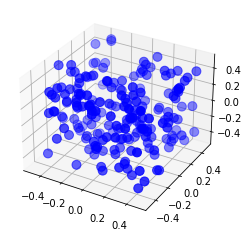

In [5]:
exc_fig = nest.PlotLayer(exc_pop, nodesize=80)

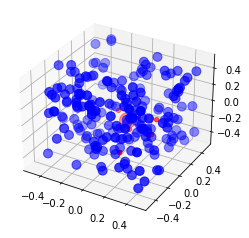

In [6]:
# exc pop (blue), inh pop (red)
if exc_circular_conn:
    exc_fig = nest.PlotLayer(exc_pop, nodesize=80)
    ctr = nest.FindCenterElement(exc_pop)
    final_fig = nest.PlotTargets(ctr, inh_pop, fig=exc_fig,
                     mask=exc_conn_dict['mask'], probability_parameter=exc_conn_dict['p'],
                     src_size=250, tgt_color='red', tgt_size=20, mask_color='red',
                     probability_cmap='Greens')

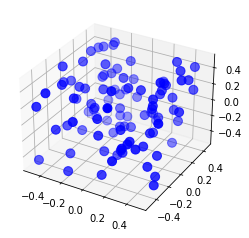

In [7]:
inh_fig = nest.PlotLayer(inh_pop, nodesize=80)

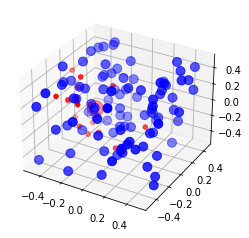

In [8]:
# inh pop (blue), exc pop (red)
if inh_circular_conn:
    inh_fig = nest.PlotLayer(inh_pop, nodesize=80)
    ctr = nest.FindCenterElement(inh_pop)
    final_fig = nest.PlotTargets(ctr, exc_pop, fig=inh_fig,
                     mask=inh_conn_dict['mask'], probability_parameter=inh_conn_dict['p'],
                     src_size=250, tgt_color='red', tgt_size=20, mask_color='red',
                     probability_cmap='Greens')

In [9]:
# recording

## voltmeter
voltmeter = nest.Create("voltmeter")
if neuron_model_name=="edlif_psc_percent":
    voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c"]})
    voltmeter.set({"record_from": ["V_m"]})
else:
    voltmeter.set({"record_from": ["V_m"]})
nest.Connect(voltmeter, exc_pop)
nest.Connect(voltmeter, inh_pop)

## multimeter
#multimeter = nest.Create("multimeter")
#multimeter.set(record_from=["V_m"])

## spike recorder
spikerecorder = nest.Create("spike_recorder")

## weight recorder
#exc_wr = nest.Create('weight_recorder')
#nest.CopyModel(exc_synapse_model, "exc_stdp_synapse_rec", {"weight_recorder": exc_wr})
#inh_wr = nest.Create('weight_recorder')
#nest.CopyModel(inh_synapse_model, "inh_stdp_synapse_rec", {"weight_recorder": inh_wr})

## connections to devices
#nest.Connect(multimeter, exc_pop)
#nest.Connect(multimeter, inh_pop)
nest.Connect(exc_pop, spikerecorder)
nest.Connect(inh_pop, spikerecorder)


Jun 22 16:11:29 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.


In [10]:
exc_inh_w_per_iter = []
for _ in range(iterations):
    nest.Simulate(simtime)
    exc_inh_conn = nest.GetConnections(exc_pop, inh_pop)
    #print(exc_inh_w)
    exc_inh_w_per_iter.append(exc_inh_conn.get("weight"))


Jun 22 16:11:29 NodeManager::prepare_nodes [Info]: 
    Preparing 306 nodes for simulation.

Jun 22 16:11:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 306
    Simulation time (ms): 50
    Number of OpenMP threads: 1
    Not using MPI
alpha: -1 
beta: 0.0421095 
V_abs: 0.631642 mV
alpha: -1 
beta: 0.0423101 
V_abs: 0.634652 mV
alpha: -1 
beta: 0.041936 
V_abs: 0.629041 mV
alpha: -1 
beta: 0.0412394 
V_abs: 0.618592 mV
alpha: -1 
beta: 0.0430489 
V_abs: 0.645734 mV
alpha: -1 
beta: 0.0438699 
V_abs: 0.658049 mV
alpha: -1 
beta: 0.0425769 
V_abs: 0.638653 mV
alpha: -1 
beta: 0.0425236 
V_abs: 0.637854 mV
alpha: -1 
beta: 0.0423411 
V_abs: 0.635117 mV
alpha: -1 
beta: 0.0426097 
V_abs: 0.639145 mV
alpha: -1 
beta: 0.0422631 
V_abs: 0.633947 mV
alpha: -1 
beta: 0.0400918 
V_abs: 0.601377 mV
alpha: -1 
beta: 0.042358 
V_abs: 0.63537 mV
alpha: -1 
beta: 0.0426131 
V_abs: 0.639196 mV
alpha: -1 
beta: 0.0421319 
V_abs: 0.631979 mV
alpha: -1 
beta: 0.0445359 
V_abs:

this is an exc neuron


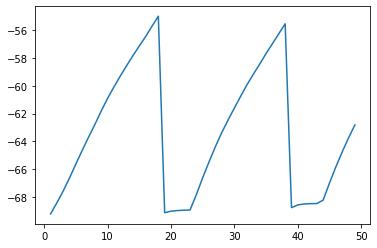

In [11]:
# Extracting voltimeter data
def get_neuron_vm(neuron_idx):
    if neuron_idx >= exc_n+inh_n:
        raise Exception(f"neuron idx should be < {exc_n+inh_n}")
    if neuron_idx >= exc_n:
        print("this is an inh neuron")
    else:
        print("this is an exc neuron")
    #dmm = multimeter.get()
    dmm = voltmeter.get()
    Vms = dmm["events"]["V_m"][neuron_idx::exc_n+inh_n]
    ts = dmm["events"]["times"][neuron_idx::exc_n+inh_n]
    return Vms, ts

neuron_idx = 5
Vms, ts = get_neuron_vm(neuron_idx)
plt.plot(ts, Vms)

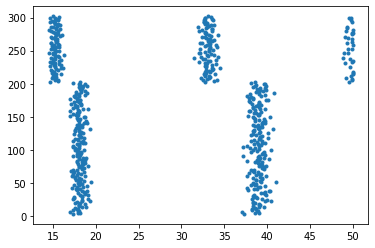

In [12]:
# extracting spikes data
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.plot(ts, evs, ".")

{'ports': array([ 17,  18,  19, ..., 960, 961, 249]), 'receptors': array([0, 0, 0, ..., 0, 0, 0]), 'senders': array([  6,   6,   6, ..., 186, 186,  52]), 'targets': array([287, 298, 253, ..., 301, 210, 293]), 'times': array([17. , 17. , 17. , ..., 40.8, 40.8, 41. ]), 'weights': array([1.06866272, 2.83192869, 4.76290866, ..., 1.41413486, 2.73067182,
       1.59447527])}


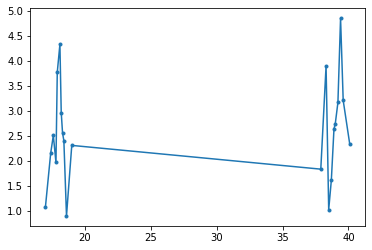

In [13]:
# extracting exc weights value data
# TODO: Fix this function! is totally wrong
def get_weight_value(pre_neuron_idx, post_neuron_idx):
    exc_inh_w  = exc_inh_wr.get("events")
    print(exc_inh_w )
    w = exc_inh_w ["weights"][pre_neuron_idx::(inh_n+1)]
    ts = exc_inh_w["times"][pre_neuron_idx::(inh_n+1)]

    return ts, w

pre_idx = 0
post_idx = 0
ts, w = get_weight_value(pre_idx, post_idx)
plt.plot(ts, w, ".-")

{'ports': array([ 636,  637,  638, ..., 1072, 1073, 1074]), 'receptors': array([0, 0, 0, ..., 0, 0, 0]), 'senders': array([247, 247, 247, ..., 281, 281, 281]), 'targets': array([ 32, 133, 161, ...,  43,  14,  77]), 'times': array([14.5, 14.5, 14.5, ..., 50. , 50. , 50. ]), 'weights': array([3.83493274, 3.45572198, 4.77756951, ..., 6.46942515, 3.98052954,
       5.63172958])}


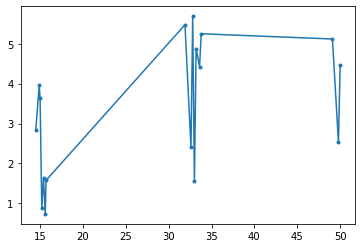

In [14]:
# extracting inh weights value data
# TODO: Fix this function! is totally wrong
def get_weight_value(pre_neuron_idx, post_neuron_idx):
    inh_exc_w = inh_exc_wr.get("events")
    print(inh_exc_w)
    w = inh_exc_w["weights"][post_neuron_idx::exc_n]
    ts = inh_exc_w["times"][post_neuron_idx::exc_n]

    return ts, w

pre_idx = 0
post_idx = 3
ts, w = get_weight_value(pre_idx, post_idx)
plt.plot(ts, w, ".-")

[[4.082394758289625, 3.6530438909174587, 5.021306838461833, 1.6329465995911883, 5.238500459833354, 2.244899415211016, 1.7271924089775645, 4.414831298297263, 1.8184614934477934, 4.667728653823556, 2.486439874831598, 1.6612598413104953, 2.5056672725063716, 5.227749472085836, 4.5943972552112005, 3.3261351314716414, 2.4312191821940625, 1.4691273548605186, 3.194809836483821, 5.103152103935116, 4.111172540041041, 3.443311981332099, 4.697277998316266, 2.389159731616076, 1.7383197335380778, 4.930480652058047, 2.6319058325833278, 4.997019340077964, 2.4725747271216125, 4.954568050461765, 2.609217755166886, 2.5510925628328995, 0.9628247594602426, 2.320376021816525, 4.0491024659573, 5.232243798527344, 1.7456234734129976, 1.37103376160563, 3.426513747538034, 3.37722069218891, 2.133274237126203, 3.08440624605547, 4.650882483431064, 4.204379523833098, 1.5872477950507797, 4.07136718281321, 1.0574301250632734, 4.863376494021242, 2.4492431705264694, 5.278386521466995, 2.122499449699744, 3.18421620981589

 ...]

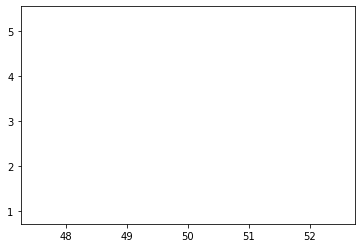

In [15]:
print(exc_inh_w_per_iter)
time = np.arange(simtime, simtime*(iterations+1), simtime)
print(time)
plt.plot(time, exc_inh_w_per_iter)